## Import packages

In [1]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

## Read and preprocess the data

The daily data

In [2]:
# Loading/Reading in the Data
df_daily = pd.read_csv("BTC_daily.csv")

# Data Preprocessing
### Setting the datetime index as the date, only selecting the 'Close' column, then only the last 300 closing prices.
df_daily = df_daily.set_index("Date")[['Close']].tail(300)
df_daily = df_daily.set_index(pd.to_datetime(df_daily.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df_daily = pd.DataFrame(scaler.fit_transform(df_daily), columns=df_daily.columns, index=df_daily.index)
df_daily

,Close
Date,
2021-08-04,0.285571
2021-08-05,0.314387
2021-08-06,0.364386
2021-08-07,0.409053
2021-08-08,0.389595
...,...
2022-05-26,0.016427
2022-05-27,0.000000
2022-05-28,0.004811


The hourly data

In [3]:
df_hourly = pd.read_csv("BTC_hourly.csv", header = 1)

# Data Preprocessing
### Setting the datetime index as the date, only selecting the 'Close' column, then only the last 300 closing prices.
df_hourly = df_hourly.set_index("date")[['close']].head(300).iloc[::-1]
df_hourly = df_hourly.set_index(pd.to_datetime(df_hourly.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df_hourly = pd.DataFrame(scaler.fit_transform(df_hourly), columns=df_hourly.columns, index=df_hourly.index)
df_hourly

,close
date,
2022-05-17 13:00:00,0.986872
2022-05-17 14:00:00,0.777571
2022-05-17 15:00:00,0.813835
2022-05-17 16:00:00,0.813044
2022-05-17 17:00:00,0.784554
...,...
2022-05-29 20:00:00,0.367860
2022-05-29 21:00:00,0.389879
2022-05-29 22:00:00,0.481030


## Functions to use for visualizing the result, splitting data, and layer making

In [4]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,6))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(history['val_rmse'])
    plt.plot(history['rmse'])
    plt.legend(['val_rmse', 'rmse'])
    plt.title('RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.show()
    
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    creates two arrays: X and y. 
    These variables are the input and output variables respectively for our Neural Network. 
    The input is the number of periods to look back and the output is the number of periods ahead. 
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

def layer_maker(model, n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option, dropout layer to prevent potential overfitting if necessary
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1, n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

## Functions to create our Recurrent Neural Network--LSTM

In [5]:
def init_model() :
    # Instantiating the model
    model = Sequential()

    # Activation
    activ = "softsign"

    # Input layer
    model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

    # Hidden layers
    layer_maker(model, n_layers=12, n_nodes=24, activation=activ, drop=2)

    # Final Hidden layer
    model.add(LSTM(10, activation=activ))

    # Output layer
    model.add(Dense(n_per_out))

    # Model summary
    model.summary()
    return model

## Model parameters and period units

The daily model

In [6]:
"""
We choose to look back on 30 days of price history to predict the next 10 days.
"""

# How many periods looking back to train
n_per_in  = 30

# How many periods ahead to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X_daily, y_daily = split_sequence(list(df_daily.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X_daily = X_daily.reshape((X_daily.shape[0], X_daily.shape[1], n_features))
print(X_daily.shape, y_daily.shape)

(261, 30, 1) (261, 10)


The hourly model

In [7]:
"""
We choose to look back on 30 hours of price history to predict the next 10 hours.
"""

# Splitting the data into appropriate sequences
X_hourly, y_hourly = split_sequence(list(df_hourly.close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X_hourly = X_hourly.reshape((X_hourly.shape[0], X_hourly.shape[1], n_features))
print(X_hourly.shape, y_hourly.shape)

(261, 30, 1) (261, 10)


## Fit the model by trying 200 epochs

In [8]:
model = init_model()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=400,
    decay_rate=0.9)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=[tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None),
                       tf.keras.metrics.RootMeanSquaredError(name="rmse", dtype=None)])

2022-06-12 18:32:16.272984: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 30, 24)            5280      
                                                                 
 lstm_2 (LSTM)               (None, 30, 24)            4704      
                                                                 
 dropout (Dropout)           (None, 30, 24)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 24)            4704      
                                                                 
 lstm_4 (LSTM)               (None, 30, 24)            4704      
                                                                 
 dropout_1 (Dropout)         (None, 30, 24)            0

The daily model

In [9]:
res_daily = model.fit(X_daily, y_daily, epochs=200, batch_size=32, validation_split=0.1)

Epoch 1/200
8/8 [==============================] - 16s 363ms/step - loss: 0.2527 - mean_squared_error: 0.2527 - rmse: 0.5027 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_rmse: 0.1056
Epoch 2/200
8/8 [==============================] - 1s 85ms/step - loss: 0.1900 - mean_squared_error: 0.1900 - rmse: 0.4359 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_rmse: 0.1419
Epoch 3/200
8/8 [==============================] - 1s 87ms/step - loss: 0.1338 - mean_squared_error: 0.1338 - rmse: 0.3658 - val_loss: 0.0564 - val_mean_squared_error: 0.0564 - val_rmse: 0.2374
Epoch 4/200
8/8 [==============================] - 1s 84ms/step - loss: 0.0950 - mean_squared_error: 0.0950 - rmse: 0.3082 - val_loss: 0.1271 - val_mean_squared_error: 0.1271 - val_rmse: 0.3565
Epoch 5/200
8/8 [==============================] - 1s 87ms/step - loss: 0.0764 - mean_squared_error: 0.0764 - rmse: 0.2764 - val_loss: 0.1711 - val_mean_squared_error: 0.1711 - val_rmse: 0.4136
Epoch 6/200
8/8 [===========

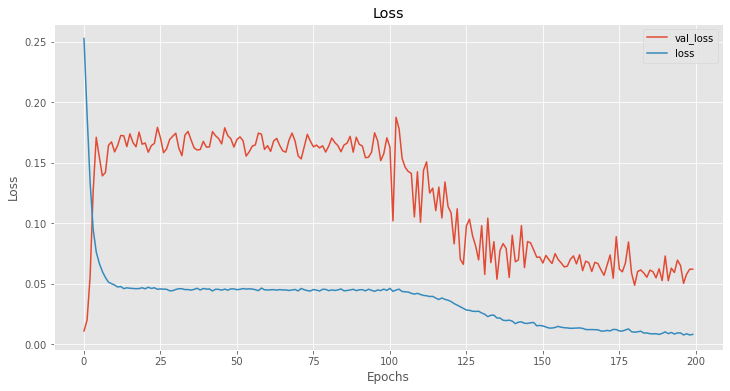

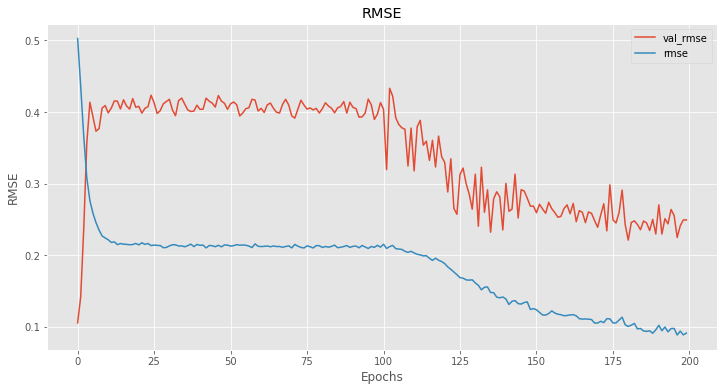

In [10]:
visualize_training_results(res_daily)

The hourly model

In [11]:
res_hourly = model.fit(X_hourly, y_hourly, epochs=200, batch_size=32, validation_split=0.1)

Epoch 1/200
8/8 [==============================] - 1s 135ms/step - loss: 0.0628 - mean_squared_error: 0.0628 - rmse: 0.2506 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_rmse: 0.0714
Epoch 2/200
8/8 [==============================] - 1s 132ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - rmse: 0.2271 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_rmse: 0.1131
Epoch 3/200
8/8 [==============================] - 1s 133ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - rmse: 0.2238 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_rmse: 0.1492
Epoch 4/200
8/8 [==============================] - 1s 132ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - rmse: 0.2126 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_rmse: 0.1193
Epoch 5/200
8/8 [==============================] - 1s 131ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - rmse: 0.2117 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_rmse: 0.0988
Epoch 6/200
8/8 [========

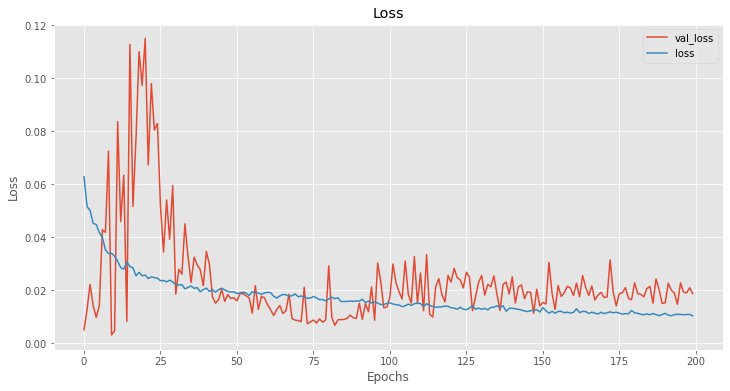

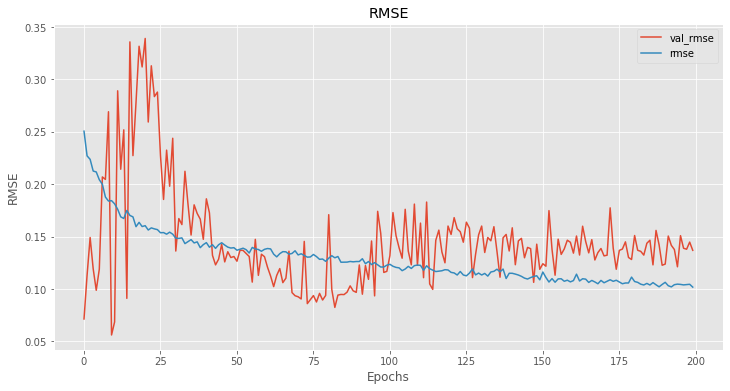

In [12]:
visualize_training_results(res_hourly)

## Test our model with comparison against actual data

In [13]:
# Getting predictions of x_daily and transform them back to normal prices
yhat_daily = model.predict(X_daily[-1].reshape(1, n_per_in, n_features)).tolist()[0]
yhat_daily = scaler.inverse_transform(np.array(yhat_daily).reshape(-1,1)).tolist()

# Getting the actual values of y_daily
actual_daily = scaler.inverse_transform(y_daily[-1].reshape(-1,1))

print("\nActual Prices for the next 10 days:\n", actual_daily.tolist())
print("Predicted Prices for the next 10 days:\n", yhat_daily)

# Getting predictions of x_hourly and transform them back to normal prices
yhat_hourly = model.predict(X_hourly[-1].reshape(1, n_per_in, n_features)).tolist()[0]
yhat_hourly = scaler.inverse_transform(np.array(yhat_hourly).reshape(-1,1)).tolist()

# Getting the actual values of y_hourly
actual_hourly = scaler.inverse_transform(y_hourly[-1].reshape(-1,1))

print("\nActual Prices for the next 10 hours:\n", actual_hourly.tolist())
print("Predicted Prices for the next 10 hours:\n", yhat_hourly)

print("\n")


Actual Prices for the next 10 days:
 [[28426.88897838975], [28476.068728006838], [28408.501441340242], [28439.210690423468], [28434.067916367643], [28417.78657755169], [28382.5], [28392.83392553038], [28427.64642531932], [28553.447484967168]]
Predicted Prices for the next 10 days:
 [[28780.373009270428], [28759.54354469478], [28750.443653672934], [28746.736253912746], [28805.80385811627], [28770.840033984183], [28792.975345245002], [28808.908813017606], [28860.39507391453], [28887.442322552204]]

Actual Prices for the next 10 hours:
 [[29210.5], [29277.5], [29217.6], [29163.5], [29119.4], [29172.7], [29220.0], [29415.8], [29452.8], [29315.3]]
Predicted Prices for the next 10 hours:
 [[28794.582014244796], [28798.062468887867], [28812.388371403515], [28809.03656167239], [28848.248740780353], [28841.58599704653], [28874.69837794602], [28882.765780717134], [28916.674262040855], [28967.981911689043]]




做一个training data的这个图

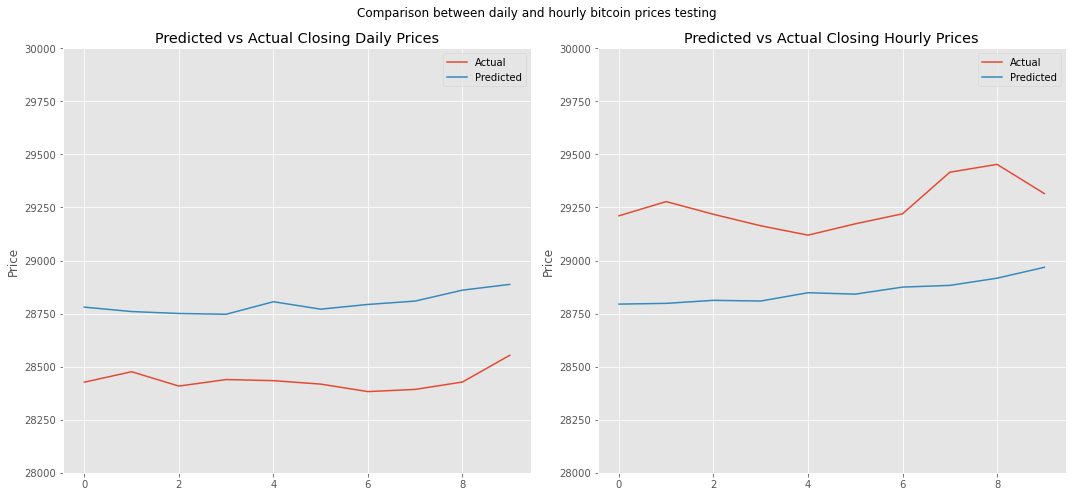

In [14]:
fig = plt.figure()
fig.set_size_inches(15, 7)
fig.suptitle("Comparison between daily and hourly bitcoin prices testing")

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_ylim([28000, 30000])
ax1.plot(actual_daily.tolist(), label='Actual')
ax1.plot(yhat_daily, label='Predicted')
ax1.set_title(f"Predicted vs Actual Closing Daily Prices")
ax1.set_ylabel("Price")
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_ylim([28000, 30000])
ax2.plot(actual_hourly.tolist(), label='Actual')
ax2.plot(yhat_hourly, label='Predicted')
ax2.set_title(f"Predicted vs Actual Closing Hourly Prices")
ax2.set_ylabel("Price")
ax2.legend()

plt.tight_layout()

## Use our model to forecast the future prices of Bitcoin

input the last 30 days worth of prices in our model.predict() method and predict Bitcoin prices for the next 10 days

                   Close
2022-05-30  28782.316255
2022-05-31  28761.047944
2022-06-01  28753.652510
2022-06-02  28752.868926
2022-06-03  28811.217315
2022-06-04  28777.651909
2022-06-05  28798.503972
2022-06-06  28815.474729
2022-06-07  28864.509086
2022-06-08  28894.835004


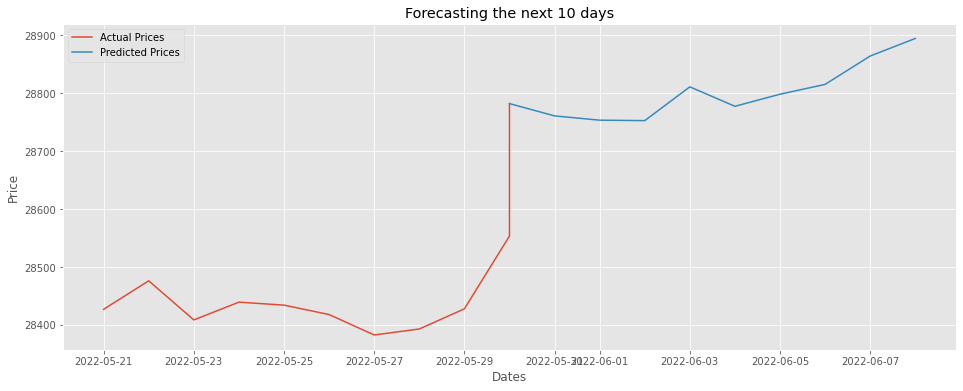

In [15]:
# Predicting daily future values and transforming to non-normal
yhat_future_daily = model.predict(np.array(df_daily.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]
yhat_future_daily = scaler.inverse_transform(np.array(yhat_future_daily).reshape(-1,1)).tolist()

# Creating a dataframe of the predicted prices
preds_daily = pd.DataFrame(yhat_future_daily, index=pd.date_range(start=df_daily.index[-1], periods=len(yhat_future_daily), freq="D"),
                           columns=df_daily.columns)

# Printing the predicted prices
print(preds_daily)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual_future_daily = pd.DataFrame(scaler.inverse_transform(df_daily[["Close"]].tail(pers)), index=df_daily.Close.tail(pers).index,
                                   columns=df_daily.columns).append(preds_daily.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual_future_daily, label="Actual Prices")
plt.plot(preds_daily, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat_future_daily)} days")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()

input the last 30 hours worth of prices in our model.predict() method and predict Bitcoin prices for the next 10 hours

                            close
2022-05-30 00:00:00  29202.768831
2022-05-30 01:00:00  29204.954610
2022-05-30 02:00:00  29203.111841
2022-05-30 03:00:00  29224.144500
2022-05-30 04:00:00  29175.063857
2022-05-30 05:00:00  29242.944518
2022-05-30 06:00:00  29228.581549
2022-05-30 07:00:00  29239.750514
2022-05-30 08:00:00  29216.710047
2022-05-30 09:00:00  29304.836453


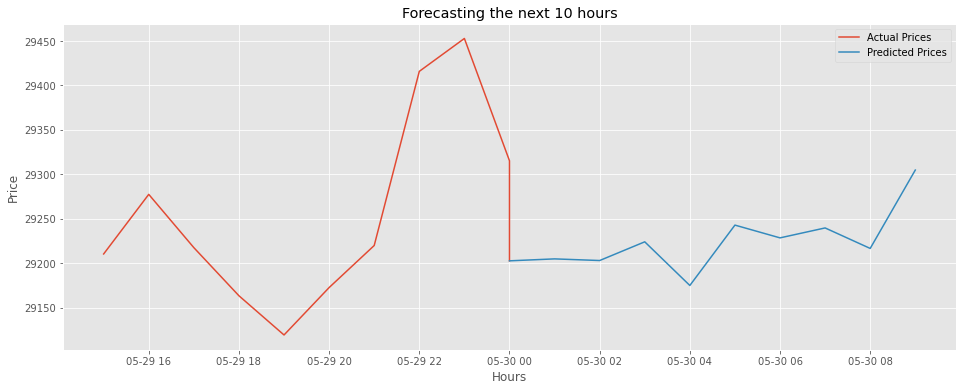

In [16]:
# Predicting hourly future values and transforming to non-normal
yhat_future_hourly = model.predict(np.array(df_hourly.head(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]
yhat_future_hourly = scaler.inverse_transform(np.array(yhat_future_hourly).reshape(-1,1)).tolist()

# Creating a dataframe of the predicted prices
preds_hourly = pd.DataFrame(yhat_future_hourly, index=pd.date_range(start=df_hourly.index[-1], periods=len(yhat_future_hourly), freq="1H"),
                           columns=df_hourly.columns)

# Printing the predicted prices
print(preds_hourly)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual_future_hourly = pd.DataFrame(scaler.inverse_transform(df_hourly[["close"]].tail(pers)), index=df_hourly.close.tail(pers).index,
                                   columns=df_hourly.columns).append(preds_hourly.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual_future_hourly, label="Actual Prices")
plt.plot(preds_hourly, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Hours")
plt.title(f"Forecasting the next {len(yhat_future_daily)} hours")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()

用absolute的 和 percent change分别做，对比